In [14]:
import torch
import numpy as np
import os
import pytorch_lightning as pl

from torchphysics.problem import Variable
from torchphysics.setting import Setting
from torchphysics.problem.domain import Interval
from torchphysics.problem.condition import (DirichletCondition,
                                            DiffEqBoundaryCondition,
                                            DiffEqCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import grad

from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()

False

In [15]:
# First define all parameters:
L = 1 # Länge von Gebiet
u_m = 3.5 #m/s 0.26
beta = 2.2*1e-08 # 2.2e-08 m^2/N
nu0 = 1e-04
nu1 = 1e-1

In [16]:
def nu_func(nu,p):
    out = nu * torch.exp(beta * p)
    return out

In [17]:
# Variables:
x = Variable(name='x',
             order=1,
             domain=Interval(0, L),
             train_conditions={},
             val_conditions={})
nu = Variable(name='nu',
             order=1,
             domain=Interval(low_bound=nu0,
                             up_bound=nu1),
             train_conditions={},
             val_conditions={})
# Output:
p = 'p'

In [18]:
norm = torch.nn.MSELoss()

nu_points = 300 # number of nu-points for the boundary condition.
def bcl_fun(p, x):
    return p-1 

def bcr_fun(p, x):
    return p-1 

x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=bcl_fun,
                                              name='bcl',
                                              norm=norm,
                                              dataset_size = [1, nu_points], 
                                              sampling_strategy='lhs', # oder 'grid' 
                                              weight=20,
                                              boundary_sampling_strategy='lower_bound_only'))

x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=bcr_fun,
                                              name='bcr',
                                              norm=norm,
                                              dataset_size = [1,nu_points], 
                                              sampling_strategy='lhs', # oder 'grid' 
                                              weight=20,
                                              boundary_sampling_strategy='upper_bound_only'))

In [19]:
def pde(nu, p, x):
    # evaluate the viscosity
    nu = nu_func(nu,p)
    # implement the PDE:
    # 
    #out = h(x)*grad(grad(p,x),x) +3*h_x(x)*grad(p,x) - rs*h_x(x)/h(x)/h(x)
    p_x  = grad(p,x)
    p_xx = grad(p_x,x)
    out = - nu*p_xx + p_x + p - 2
    
    #print(torch.max(out))
    return out
   
train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             #data_fun=data_fun,
                             norm=norm,
                             weight=1.0,
                             dataset_size=[100,50],
                             sampling_strategy = {'x': 'spaced_grid', 'nu': 'grid'},
                             sampling_params={'x': {'exponent': 1/6}},
                             data_plot_variables=('x','nu'))


print('pde defined'

In [20]:
setup = Setting(variables=(x, nu),
                train_conditions={'pde': train_cond},
                val_conditions={},
                solution_dims={p: 1},
                n_iterations=400)

In [21]:
solver = PINNModule(model=SimpleFCN(variable_dims=setup.variable_dims,
                                    solution_dims=setup.solution_dims,
                                    normalization_dict=setup.normalization_dict,
                                    depth=3,
                                    width=20),
                    optimizer=torch.optim.Adam,
                    lr=1.e-2)

In [22]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=20,
                     log_every_n_steps=1,
                     max_epochs=1,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.3 K 
------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

In [ ]:
# Use LBFGS at the end
solver.lr = 0.5
solver.optimizer = torch.optim.LBFGS
solver.optim_params = {'max_iter': 1}
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=20,
                     log_every_n_steps=15,
                     max_epochs=3,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.3 K 
------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

nu0=  0.0001  nu1=  0.1


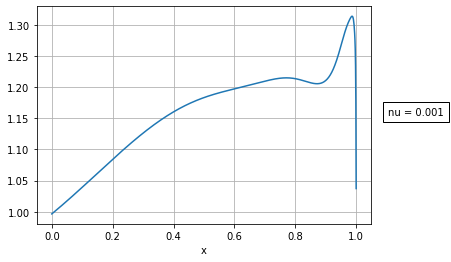

In [24]:
from torchphysics.utils.plot import _plot
solver = solver.to('cpu')
print('nu0= ',nu0,' nu1= ',nu1)
nu = 0.001
if nu0<=nu and nu<=nu1:
    fig = _plot(model=solver.model, solution_name='p', plot_variables=[x], # or [x, nu] and 
                points=1000, dic_for_other_variables={'nu': nu}) # dic_for_... = {}
else:
    print('Ausserhalb des Trainingsbereiches')